In [2]:
import json
import sys

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from astropy.io import fits

from astropy.wcs import WCS

In [8]:
sys.executable

'/net/ASTRO/brunoritter/miniconda3/envs/qperedux/bin/python'

In [2]:
# path = "/gmos/gs-2022b-q-202/"
path = ""

#### PCA tomography on combined spectra

#### Paramater space for filters exploration

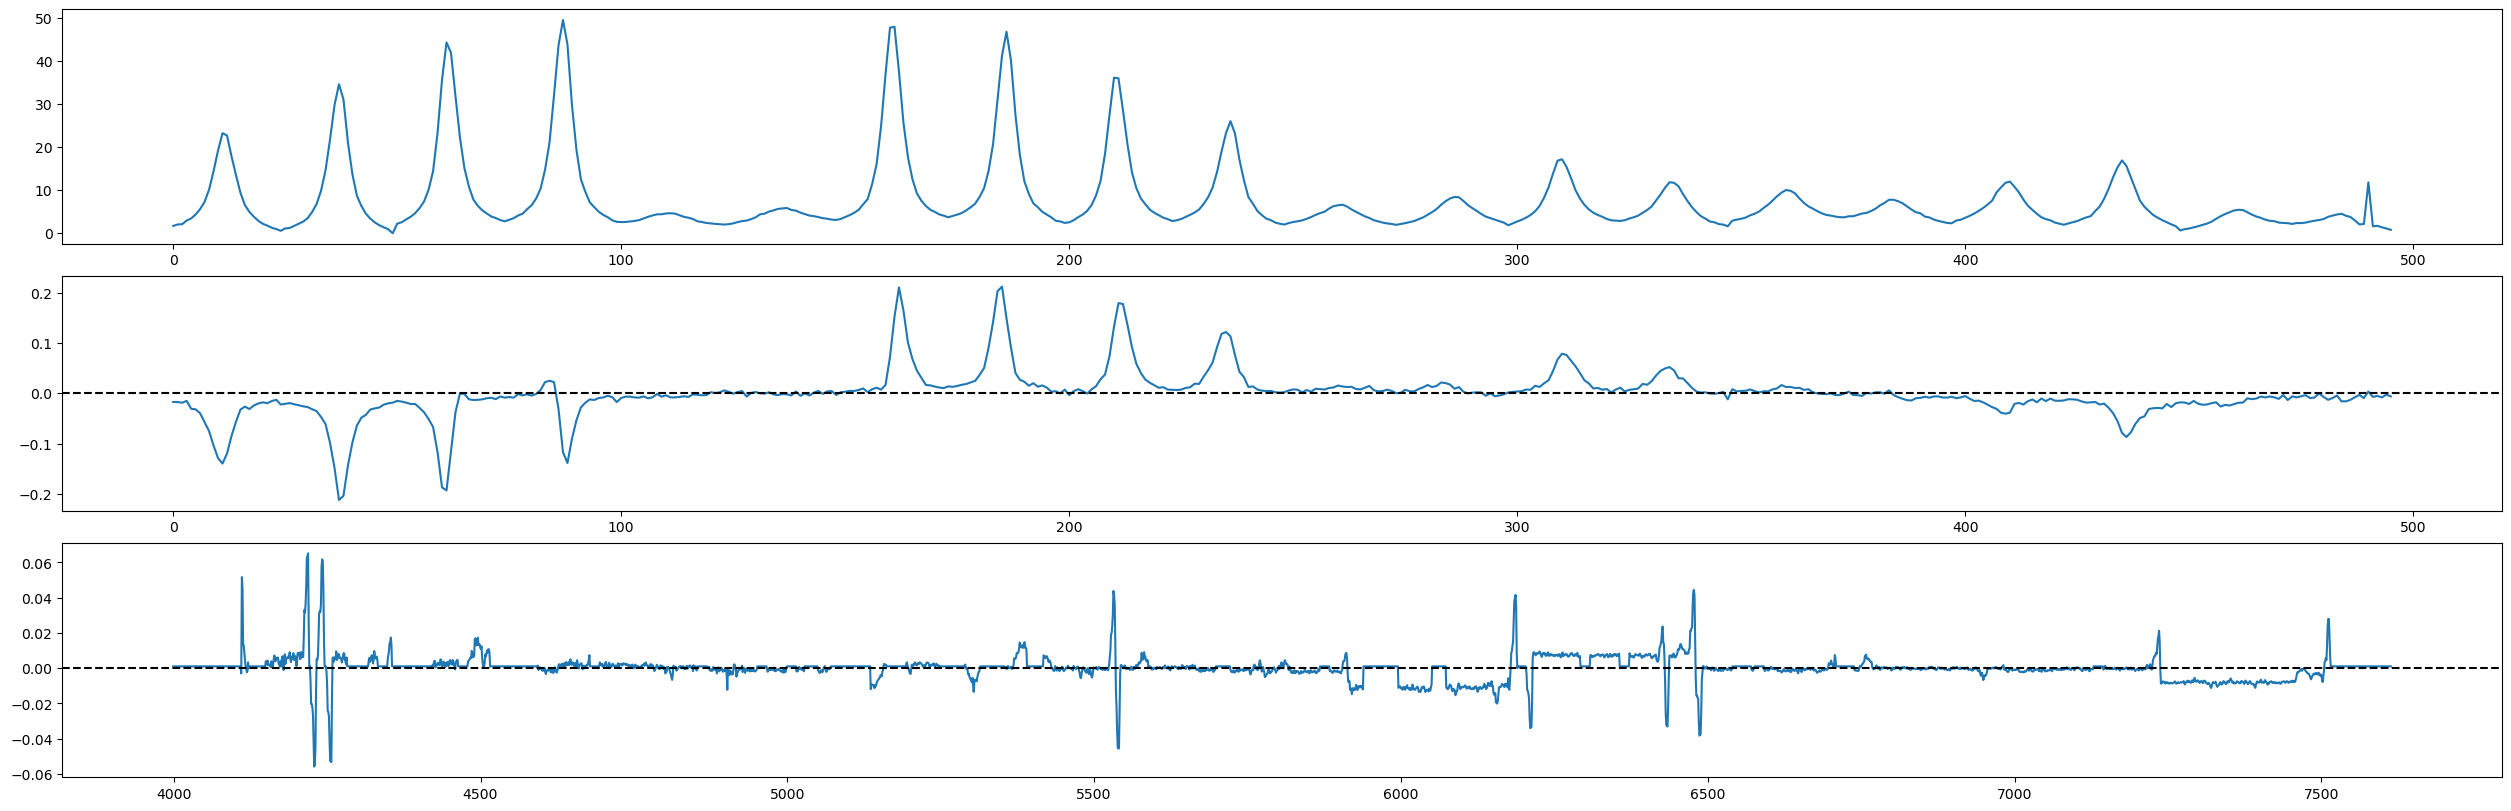

In [158]:
component = 3
data.tomography(component)

In [159]:
initial_fft_filter = 1700
initital_wavelet_filter = 5.5
initial_step_size = 5
beam = 37  # qual fibra plotar

# def restricao_param1(params):
#     # Deve ser não negativo, então retorna o valor do parâmetro.
#     # Se for negativo, a restrição não será satisfeita.
#     return params[0]


def restricao_param2(params):
    # Mesmo que acima para o segundo parâmetro.
    return params[1]


# def restricao_param3(params):
#     return params[1] - 8  # Deve ser não-positivo para satisfazer a restrição


def restricao_param4(params):
    return 1.5 - params[1]  # Deve ser não-negativo para satisfazer a restrição


constraints = [
    #    {"type": "ineq", "fun": restricao_param1},
    {"type": "ineq", "fun": restricao_param2},
    #    {"type": "ineq", "fun": restricao_param3},
    {"type": "ineq", "fun": restricao_param4},
]

stepfilter3 = data.StepSignalRemoval(component)
# step_signal3 = stepfilter3.optimize_and_remove_step_signal(initial_fft_filter, initital_wavelet_filter, initial_step_size, constraints, verbose=True, plot=True, beam=beam)

stepfilter3.calculate_and_subtract_step_signal(1726.965142774873, 3.25)
step_signal3 = stepfilter3.bad_signal
# Optimal fft: 1726.965142774873
# Optimal wavelet: 3.25

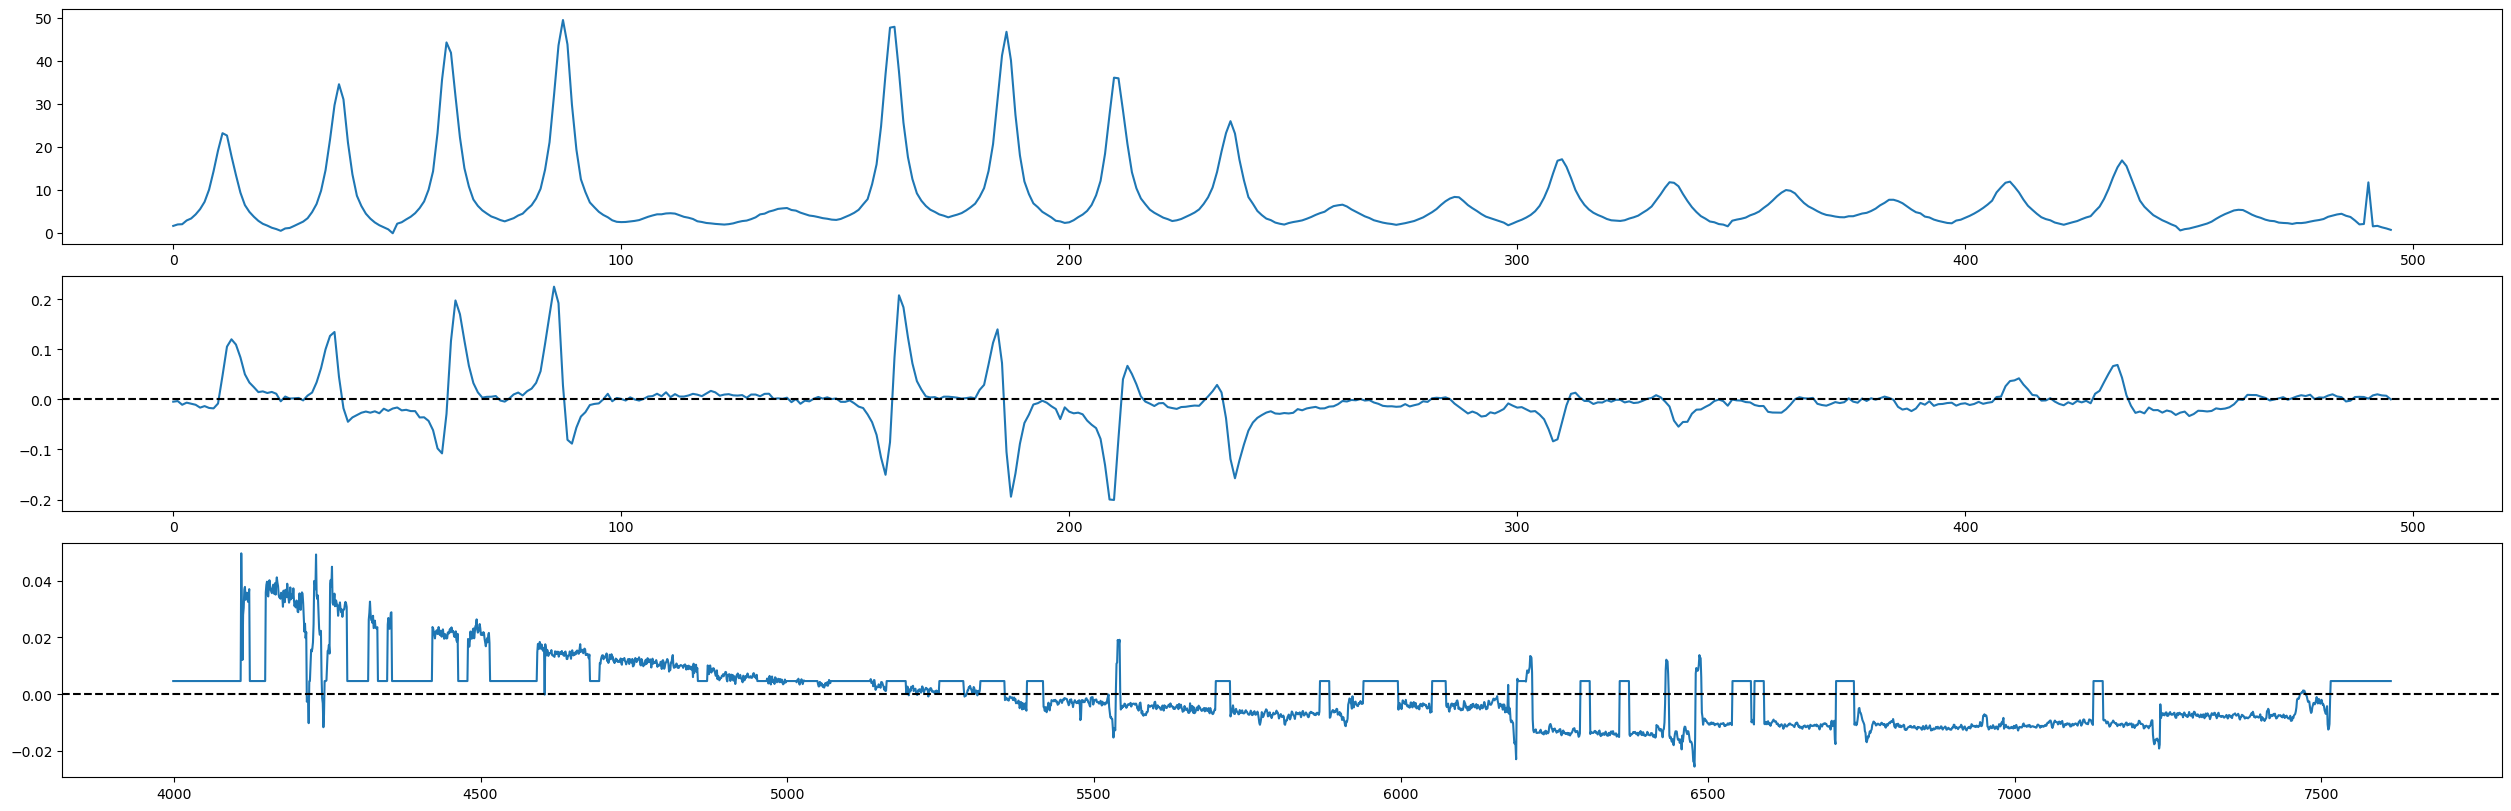

In [160]:
component = 2
data.tomography(component)

In [7]:
initial_fft_filter = 1700
initital_wavelet_filter = 20
initial_step_size = 15
beam = 37  # qual fibra plotar
stepfilter2 = data.StepSignalRemoval(component)

# def restricao_param(params):
#     return 2 - params[1]  # Deve ser não-negativo para satisfazer a restrição
# constraints = [
#     {"type": "ineq", "fun": restricao_param},

# ]

# step_signal2 = stepfilter2.optimize_and_remove_step_signal(initial_fft_filter, initital_wavelet_filter, initial_step_size, constraints, verbose=True, plot=True, beam=beam)
stepfilter2.calculate_and_subtract_step_signal(1716.404884951783, 1.5)
step_signal2 = stepfilter2.bad_signal

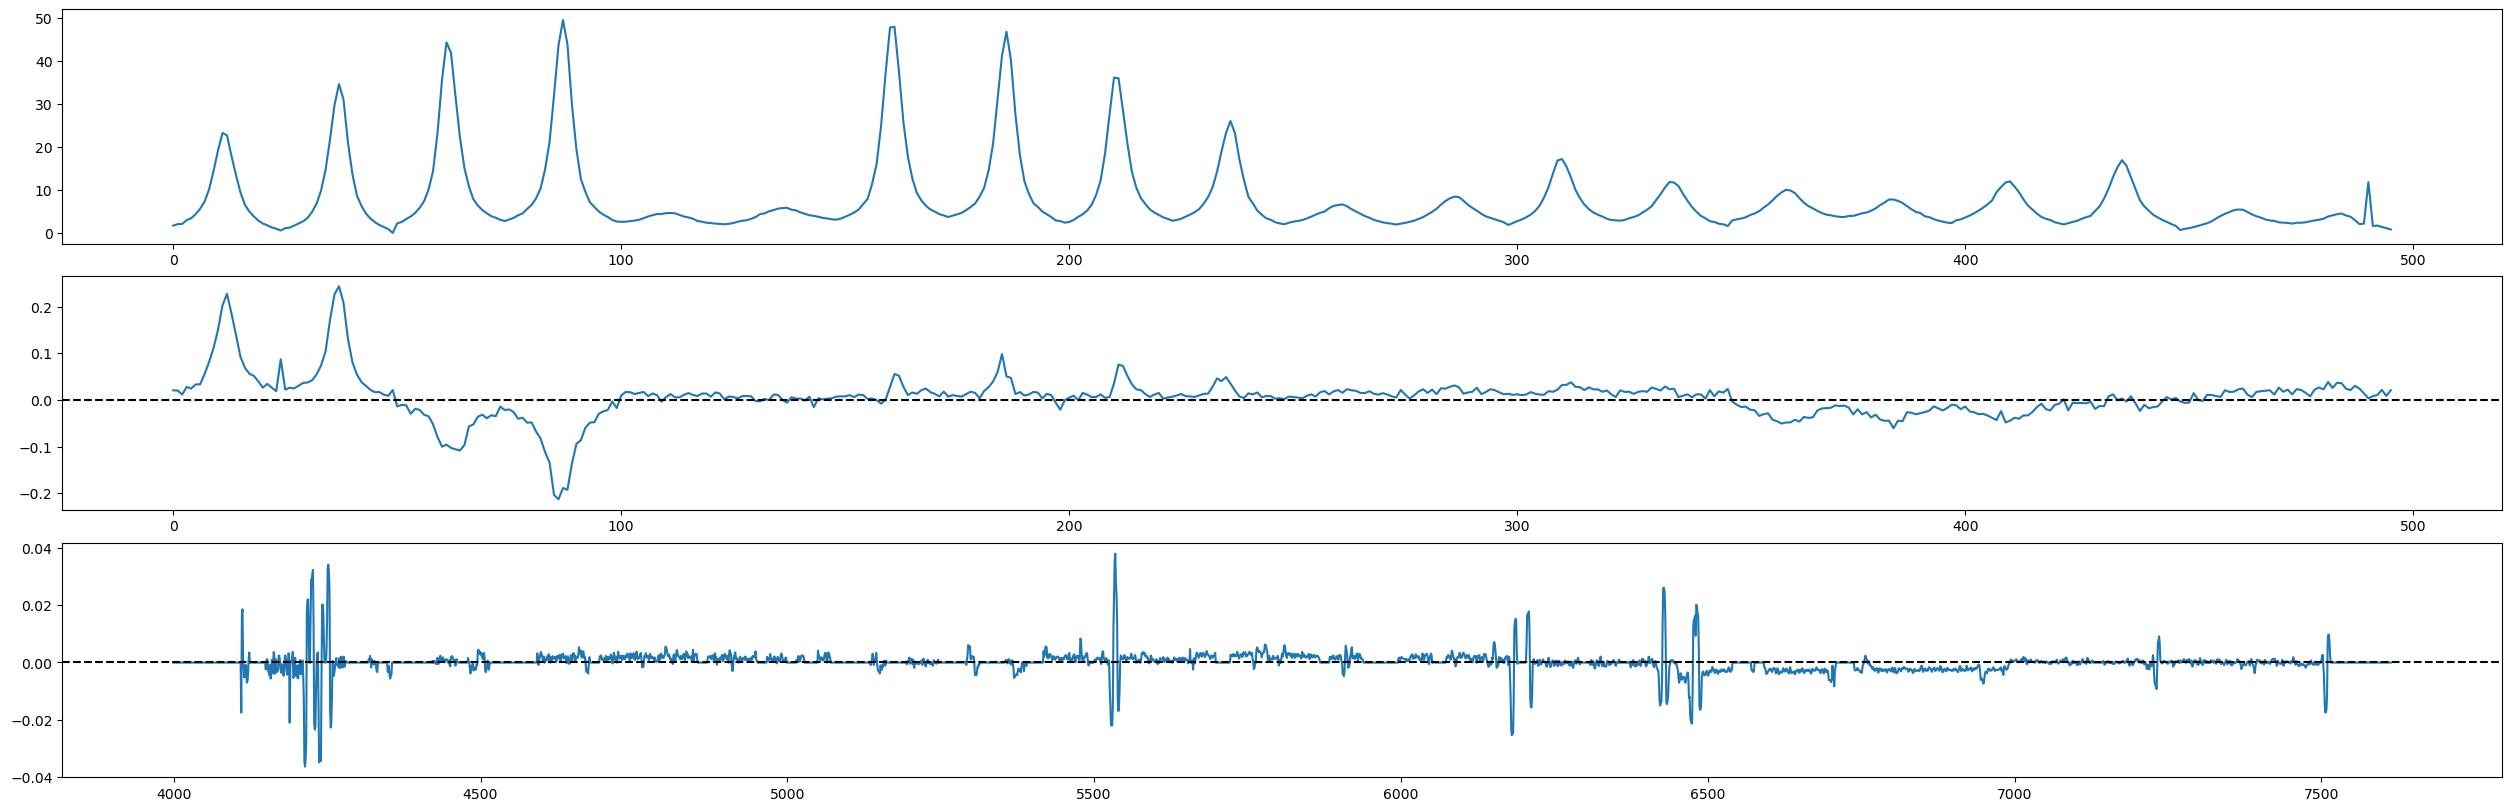

In [161]:
component = 4
data.tomography(component)

In [9]:
initial_fft_filter = 1700
initital_wavelet_filter = 20
initial_step_size = 15
beam = 37  # qual fibra plotar
stepfilter4 = data.StepSignalRemoval(component)
# step_signal4 = stepfilter4.optimize_and_remove_step_signal(initial_fft_filter, initital_wavelet_filter, initial_step_size, constraints, verbose=True, plot=True, beam=beam)

stepfilter4.calculate_and_subtract_step_signal(1703.75, 0)
step_signal4 = stepfilter4.bad_signal

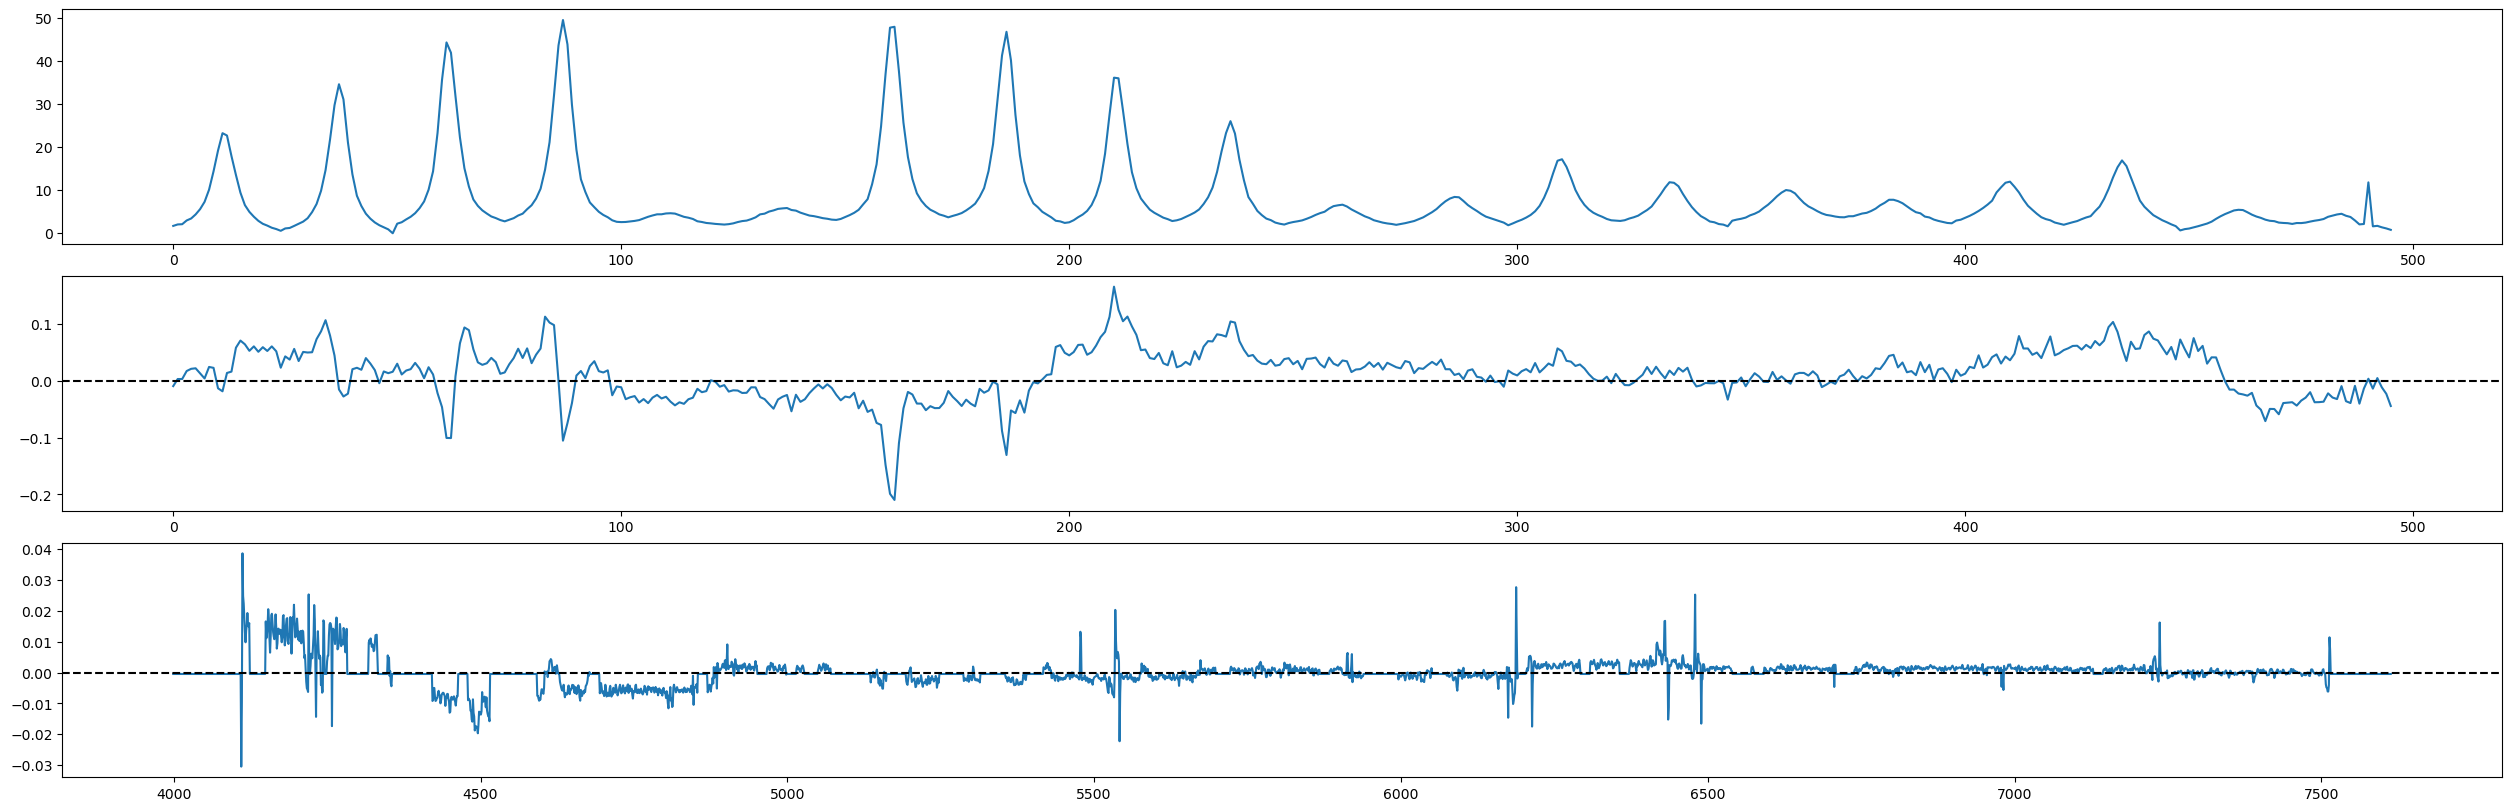

In [162]:
component = 5
data.tomography(component)

In [11]:
initial_fft_filter = 1700
initital_wavelet_filter = 20
initial_step_size = 15
beam = 37  # qual fibra plotar
stepfilter5 = data.StepSignalRemoval(component)
# step_signal5 = stepfilter5.optimize_and_remove_step_signal(initial_fft_filter, initital_wavelet_filter, initial_step_size, constraints, verbose=True, plot=True, beam=beam)
stepfilter5.calculate_and_subtract_step_signal(1703.75, 0)
step_signal5 = stepfilter5.bad_signal

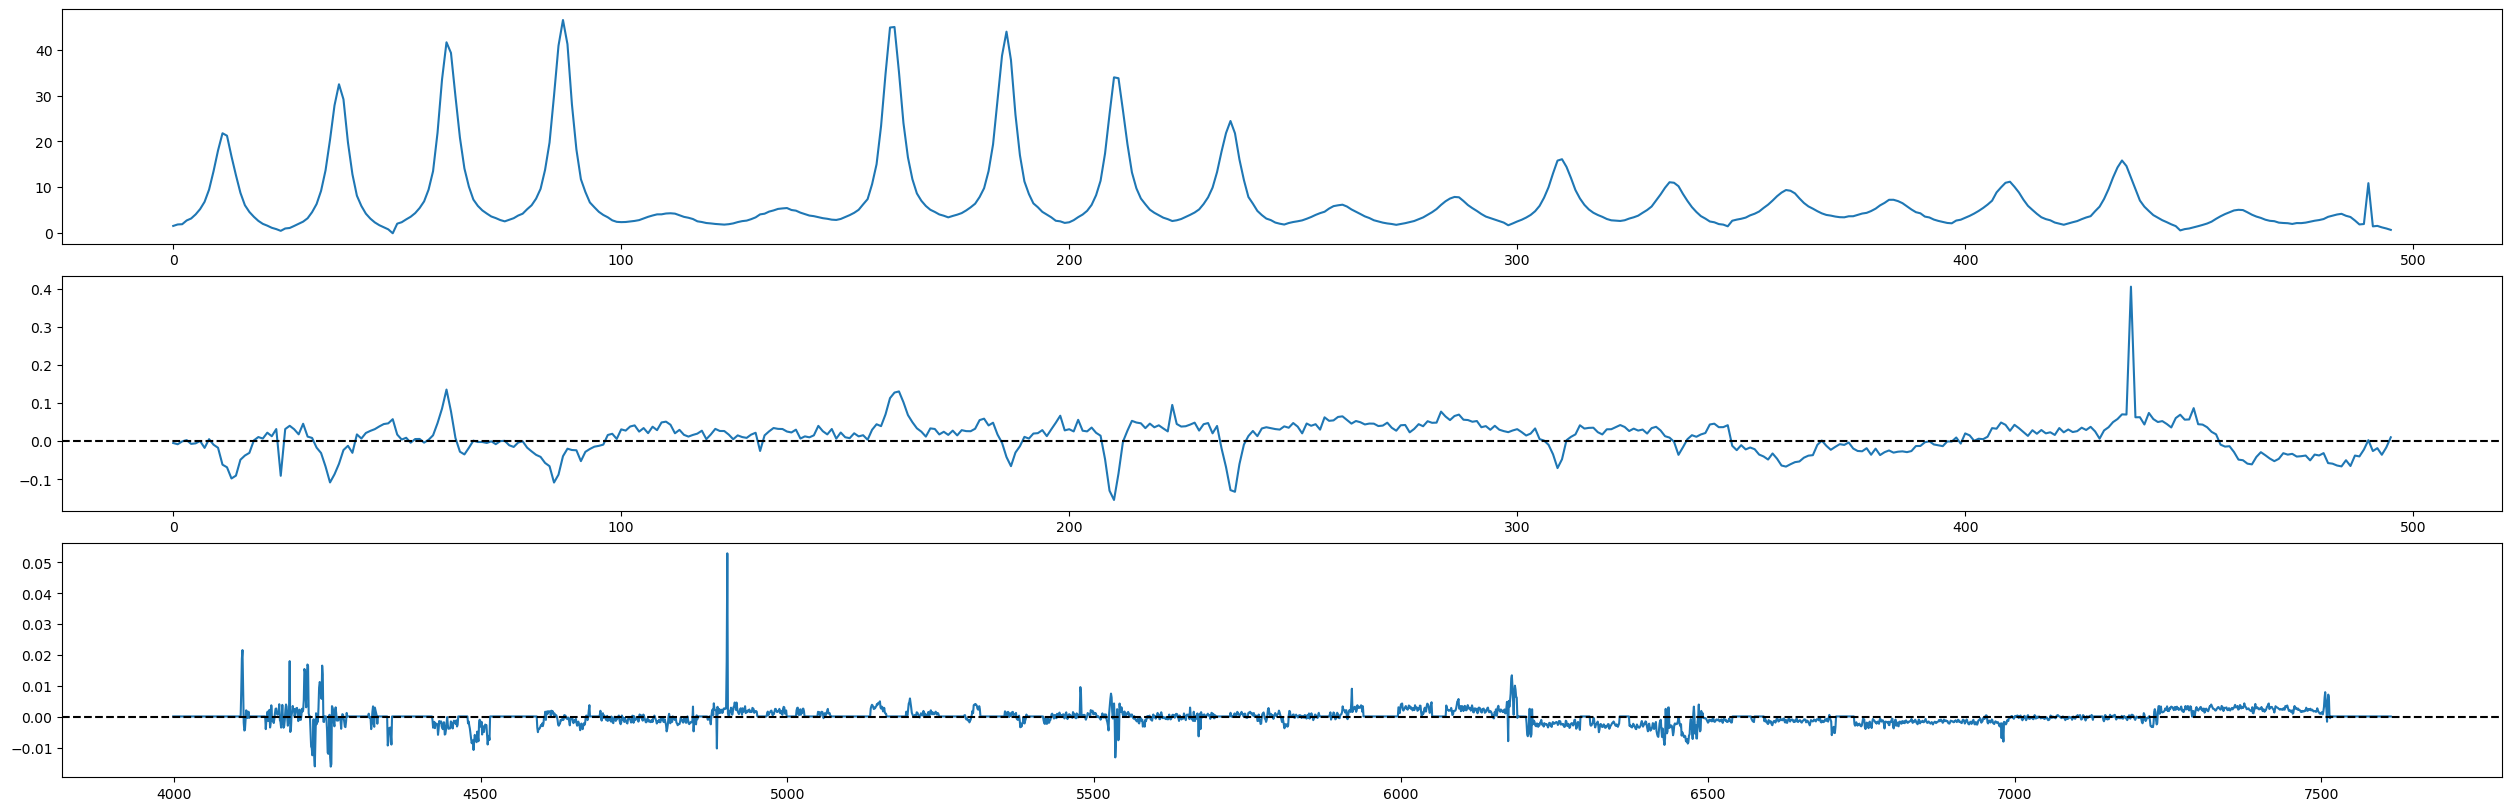

In [12]:
component = 8
data.tomography(component)

In [13]:
initial_fft_filter = 1700
initital_wavelet_filter = 20
initial_step_size = 15
beam = 37  # qual fibra plotar
stepfilter8 = data.StepSignalRemoval(component)
# step_signal8 = stepfilter8.optimize_and_remove_step_signal(initial_fft_filter, initital_wavelet_filter, initial_step_size, constraints, verbose=True, plot=True, beam=beam)
stepfilter8.calculate_and_subtract_step_signal(1694.375, 0)
step_signal8 = stepfilter8.bad_signal

#### Voronoi Binning

In [2]:
from vorbin.voronoi_2d_binning import voronoi_2d_binning

name = "gsn069"
filename = f"redux/{name}_pca_combined_spectra_ext_3D.fits"
with fits.open(filename) as hdul:
    data = hdul["SCI"].data
    var = hdul["VAR"].data
    dq = hdul["DQ"].data

fits_header = fits.getheader(filename, ext=("sci", 1))
wcs = WCS(fits_header, naxis=[3])
wavelength = wcs.wcs_pix2world(np.arange(fits_header["NAXIS3"]), 0)[0]

data.shape

the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]


(3422, 49, 33)

In [3]:
ini_index = np.where(np.round(wavelength) == 5655)[0][0]
fin_index = np.where(np.round(wavelength) == 5745)[0][0]
sample = data[ini_index:fin_index, :, :]
sample_var = var[ini_index:fin_index, :, :]
sample_noise = np.sqrt(sample_var)

print(sample.shape)
print(sample_var.shape)

(88, 49, 33)
(88, 49, 33)


Good bins: 109
Share of good bins: 0.537


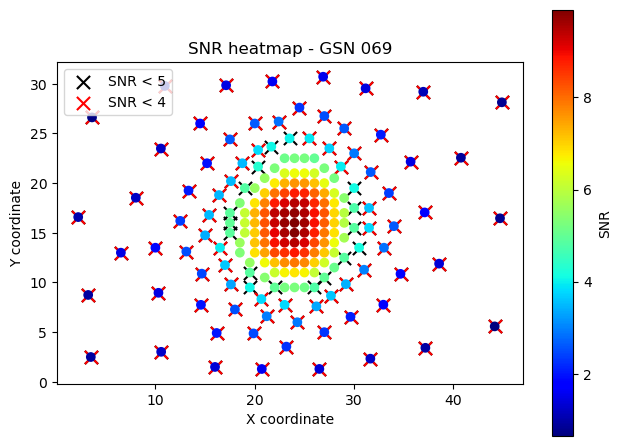

In [4]:
target_sn = 7
signal = np.nanmean(sample, axis=0)
noise = np.nanmean(sample_noise, axis=0) + 1e-10
x, y = np.indices(signal.shape)
x = x.ravel()
y = y.ravel()
bin_num, x_bin, y_bin, x_bar, y_bar, sn, n_pixels, scale = voronoi_2d_binning(
    x, y, signal.ravel(), noise.ravel(), target_sn, plot=0, quiet=1
)


threshold = 0.3
bin_ids = list(set(bin_num))
binned_data = {}
for bin_id in bin_ids:
    binned_data[bin_id] = {}
    bin_mask = bin_num == bin_id
    binx = x[bin_mask]
    biny = y[bin_mask]
    bin_mask = np.zeros(data[0, :, :].shape, dtype=bool)

    signal_sum = np.zeros(data[:, 0, 0].shape)
    var_sum = np.zeros(var[:, 0, 0].shape)

    for pixx, pixy in zip(binx, biny):
        signal_sum += data[:, pixx, pixy]
        var_sum += var[:, pixx, pixy]
        bin_mask[pixx, pixy] = True

    binned_data[bin_id]["quality_map"] = np.zeros(data.shape[0])
    for wavl in np.arange(data.shape[0]):
        wavl_dq_plane = dq[wavl, :, :]
        bad_data_ratio = np.round(
            np.sum(wavl_dq_plane[bin_mask]) / np.sum(bin_num == bin_id), 2
        )
        binned_data[bin_id]["quality_map"][wavl] = np.where(
            bad_data_ratio >= threshold, 2, 0
        ).astype(int)
    bin_signal = signal_sum / len(binx)
    bin_var = var_sum / len(binx)
    binned_data[bin_id]["signal"] = bin_signal
    binned_data[bin_id]["var"] = bin_var

true_snr = {}
for bin_id in bin_ids:
    signal = np.mean(binned_data[bin_id]["signal"][ini_index:fin_index])
    noise = np.mean(np.sqrt(binned_data[bin_id]["var"][ini_index:fin_index]))
    true_snr[bin_id] = signal / noise

all_bins = list(true_snr.keys())
x_all = np.array(x_bar)[all_bins]
y_all = np.array(y_bar)[all_bins]
snr_values = np.array(list(true_snr.values()))
good_snr_indices = [index for index, snr in enumerate(snr_values) if snr > 5]
print(f"Good bins: {len(good_snr_indices)}")
print(f"Share of good bins: {np.round(len(good_snr_indices)/len(all_bins), 3)}")
bad_snr_indices = [index for index, snr in enumerate(snr_values) if snr < 5]
really_bad_snr_indices = [index for index, snr in enumerate(snr_values) if snr < 4]

# plt.figure(figsize=(15, 10))
plt.scatter(
    x_all[bad_snr_indices],
    y_all[bad_snr_indices],
    c="black",
    marker="x",
    s=90,
    label="SNR < 5",
)
plt.scatter(
    x_all[really_bad_snr_indices],
    y_all[really_bad_snr_indices],
    c="red",
    marker="x",
    s=90,
    label="SNR < 4",
)

cmap = plt.cm.jet
sc = plt.scatter(
    x_all, y_all, c=snr_values, cmap=cmap, vmin=min(snr_values), vmax=max(snr_values)
)
plt.colorbar(sc, ax=plt.gca(), label="SNR")
plt.legend()
plt.tight_layout()
plt.gca().set_aspect("equal")
plt.title("SNR heatmap - GSN 069")
plt.xlabel("X coordinate")
plt.ylabel("Y coordinate")
plt.show()

#### Starlight pre processing

##### Pycasso resampling

In [7]:
from pycasso2.resampling import ReSamplingMatrixNonUniform


def resampling(res_lambda_min, res_lambda_max, rfwave, rfflux, rferr, qual):
    lresamp = np.arange(res_lambda_min, res_lambda_max, 1)
    matrix = ReSamplingMatrixNonUniform(rfwave, lresamp)
    fresamp = np.dot(matrix, rfflux)
    errresamp = np.dot(matrix, rferr)
    qualresamp = np.dot(matrix, qual)

    for i in range(len(qualresamp)):
        if lresamp[i] < min(rfwave):
            qualresamp[i] = 2

        elif lresamp[i] > max(rfwave):
            qualresamp[i] = 2

        if qualresamp[i] > 0:
            qualresamp[i] = 2

    return lresamp, fresamp, errresamp, qualresamp

In [28]:
lambda_min = int(np.min(wavelength))
lambda_max = int(np.max(wavelength))
res_wavelenght, res_signal, res_var, res_quality_map = resampling(
    res_lambda_min=lambda_min,
    res_lambda_max=lambda_max,
    rfwave=wavelength,
    rfflux=binned_data[0]["signal"],
    rferr=binned_data[0]["var"],
    qual=binned_data[0]["quality_map"],
)

##### Own resampling

In [31]:
# Prepare input spectrum
bin_id = 0

lambda_min = int(np.min(wavelength))
lambda_max = int(np.max(wavelength))
resampled_wavelength = np.arange(lambda_min, lambda_max, 1)

# Interpolação linear dos dados originais para o novo espaçamento de comprimentos de onda
interpolate_signal = interp1d(
    wavelength, binned_data[bin_id]["signal"], kind="linear", fill_value="extrapolate"
)
interpolate_var = interp1d(
    wavelength,
    np.sqrt(binned_data[bin_id]["var"] + 1e10),
    kind="linear",
    fill_value="extrapolate",
)

# Aplicando a interpolação para obter os novos fluxos
resampled_signal = interpolate_signal(resampled_wavelength)
resampled_var = interpolate_var(resampled_wavelength)

np.stack([resampled_wavelength, resampled_signal, resampled_var], axis=1)

array([[ 4.17000000e+03, -2.33557870e-03,  1.00000000e+05],
       [ 4.17100000e+03, -3.41014430e-03,  1.00000000e+05],
       [ 4.17200000e+03, -4.40962506e-03,  1.00000000e+05],
       ...,
       [ 7.64600000e+03,  1.79499662e-02,  1.00000000e+05],
       [ 7.64700000e+03,  1.85295525e-02,  1.00000000e+05],
       [ 7.64800000e+03,  8.01319626e-03,  1.00000000e+05]])

##### Resampling comparison

/tmp/ipykernel_52607/505559165.py:3: RuntimeWarning: invalid value encountered in divide
  plt.plot(res_wavelenght, np.clip((resampled_signal-res_signal)/res_signal, -0.5, .05))


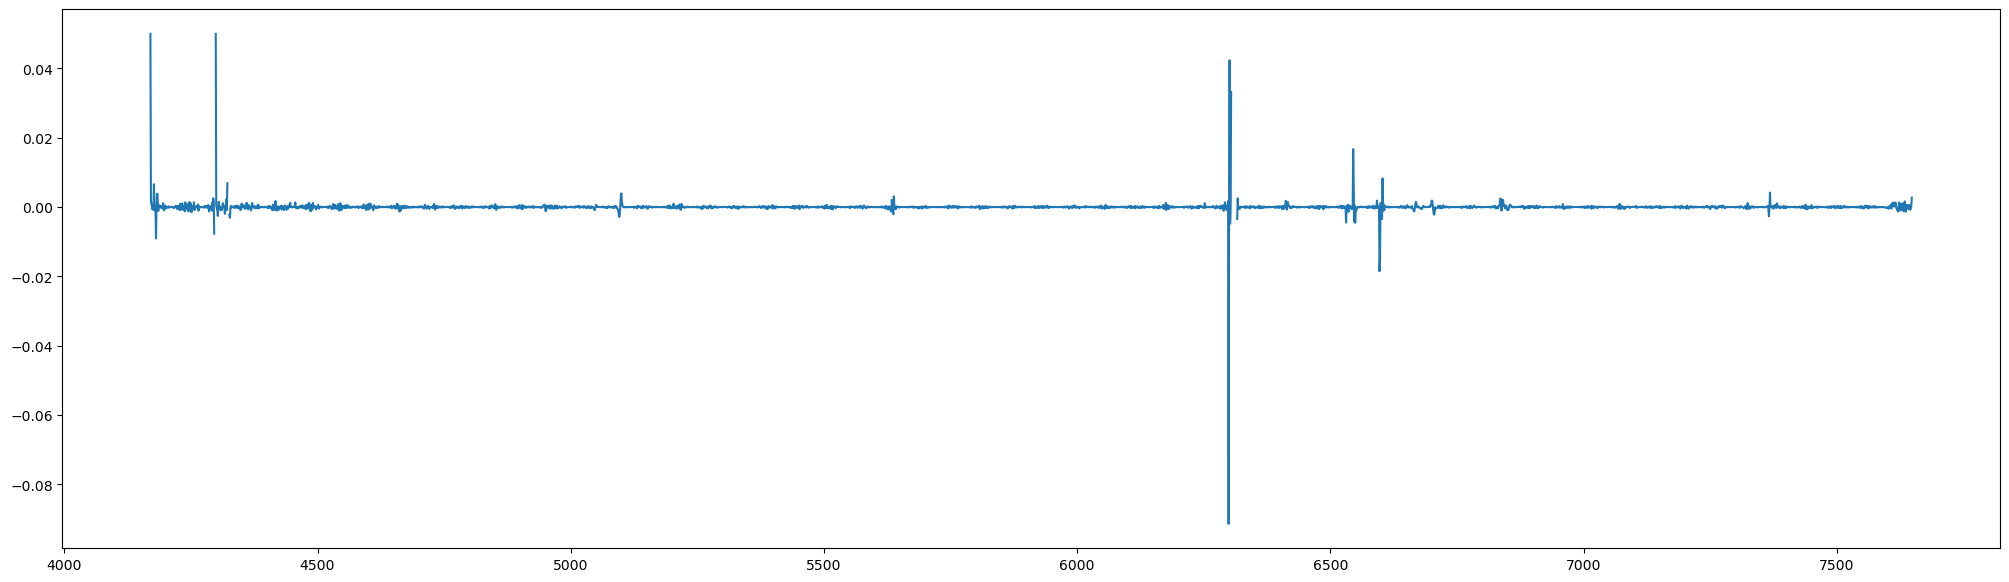

In [43]:
plt.figure(figsize=(25, 7))
# plt.plot(res_wavelenght, res_signal)
plt.plot(
    res_wavelenght, np.clip((resampled_signal - res_signal) / res_signal, -0.5, 0.05)
)

##### Proceed using pycasso

In [8]:
lambda_min = int(np.min(wavelength))
lambda_max = int(np.max(wavelength))
res_wavelenght, res_signal, res_var, res_quality_map = resampling(
    res_lambda_min=lambda_min,
    res_lambda_max=lambda_max,
    rfwave=wavelength,
    rfflux=binned_data[0]["signal"],
    rferr=binned_data[0]["var"],
    qual=binned_data[0]["quality_map"],
)

resampled_data = {}
for bin_id, bin_data in enumerate(binned_data.values()):
    res_wavelenght, res_signal, res_var, res_quality_map = resampling(
        res_lambda_min=lambda_min,
        res_lambda_max=lambda_max,
        rfwave=wavelength,
        rfflux=binned_data[bin_id]["signal"],
        rferr=binned_data[bin_id]["var"],
        qual=binned_data[bin_id]["quality_map"],
    )
    resampled_data[bin_id] = {}
    resampled_data[bin_id]["wavelength"] = res_wavelenght
    resampled_data[bin_id]["signal"] = res_signal
    resampled_data[bin_id]["var"] = res_var
    resampled_data[bin_id]["quality_map"] = res_quality_map

In [11]:
# create obs input files
for bin_id, bin_data in enumerate(resampled_data.values()):
    input_data = np.stack(
        [
            bin_data["wavelength"],
            bin_data["signal"],
            np.sqrt(bin_data["var"]),
            bin_data["quality_map"],
        ],
        axis=1,
    )
    np.savetxt(
        f"redux/starlight_synthesis/gsn069/obs_dir/{bin_id}",
        input_data,
        fmt=["%f", "%f", "%f", "%d"],
    )

/tmp/ipykernel_157720/2460282933.py:3: RuntimeWarning: invalid value encountered in sqrt
  input_data = np.stack([bin_data['wavelength'], bin_data['signal'], np.sqrt(bin_data['var']), bin_data['quality_map']], axis=1)


##### Create mask file

In [40]:
maskfilename = "MaskEmissionAbsortionGSN069"

with open("redux/gsn069_masks.json", "r") as f:
    masks_json = json.load(f)

window_range = 8
masks_json["emission_centers"] = np.round(masks_json["emission_centers"])
masks_json["emission_windows"] = [
    [emiss_center - window_range, emiss_center + window_range]
    for emiss_center in masks_json["emission_centers"]
]


all_masks = masks_json["emission_windows"]
all_masks.extend(masks_json["absortion_windows"])
nmasks = len(all_masks)

with open(f"redux/starlight_synthesis/{maskfilename}", "w") as file:
    file.write(str(nmasks) + "\n")
    for window in all_masks:
        file.write(f"{window[0]} {window[1]} 0 \n")

#### Mask exploration

In [7]:
import os


def extract_age_from_file(file_path):
    """Extract the age from the given file."""

    with open(file_path, "r") as file:

        lines = file.readlines()

        for line in lines:

            if line.strip().startswith("# Age (yr)"):

                # Extract the age value

                age = line.split()[3]

                return float(age)

    return None


def process_files_in_folder(folder_path):
    """Process all files in the given folder and return a dictionary with file names and ages."""

    age_dict = {}

    for file_name in os.listdir(folder_path):

        file_path = os.path.join(folder_path, file_name)

        if os.path.isfile(file_path):

            age = extract_age_from_file(file_path)

            if age is not None:

                age_dict[file_name] = age

    return age_dict


folder_path = "STARLIGHTv04/BasesDir"

ages_dictionary = process_files_in_folder(folder_path)

target_bases = {
    key: value for key, value in ages_dictionary.items() if 2e9 <= value <= 5e9
}
target_bases


def read_target_flux(filename, lambdamin, lambdamax):

    file_path = f"{folder_path}/{filename}"

    base = pd.read_csv(
        file_path, delim_whitespace=True, skiprows=6, names=["lambda", "flux"]
    )

    base = base[(base["lambda"] >= lambdamin) & (base["lambda"] <= lambdamax)]

    return base


def inspect_absortion_ref(
    files,
    lambdamin,
    lambdamax,
    absortion_windows: list,
):

    nplots = len(files)  # number of beams to plot

    plot_heigth = nplots * 5

    fig, ax = plt.subplots(
        nrows=nplots, ncols=1, figsize=(60, plot_heigth), sharex=True
    )

    for index, filename in enumerate(files):

        base = read_target_flux(filename, lambdamin, lambdamax)

        ax[index].plot(base["lambda"], base["flux"])

        ax[index].set_title(f"Signal of {filename}")

    for abs_window in absortion_windows:

        for figure in ax:

            figure.axvline(abs_window[0], ls="dashed", color="black", lw=0.6)

            figure.axvline(abs_window[1], ls="dashed", color="gray", lw=0.6)

    plt.show()

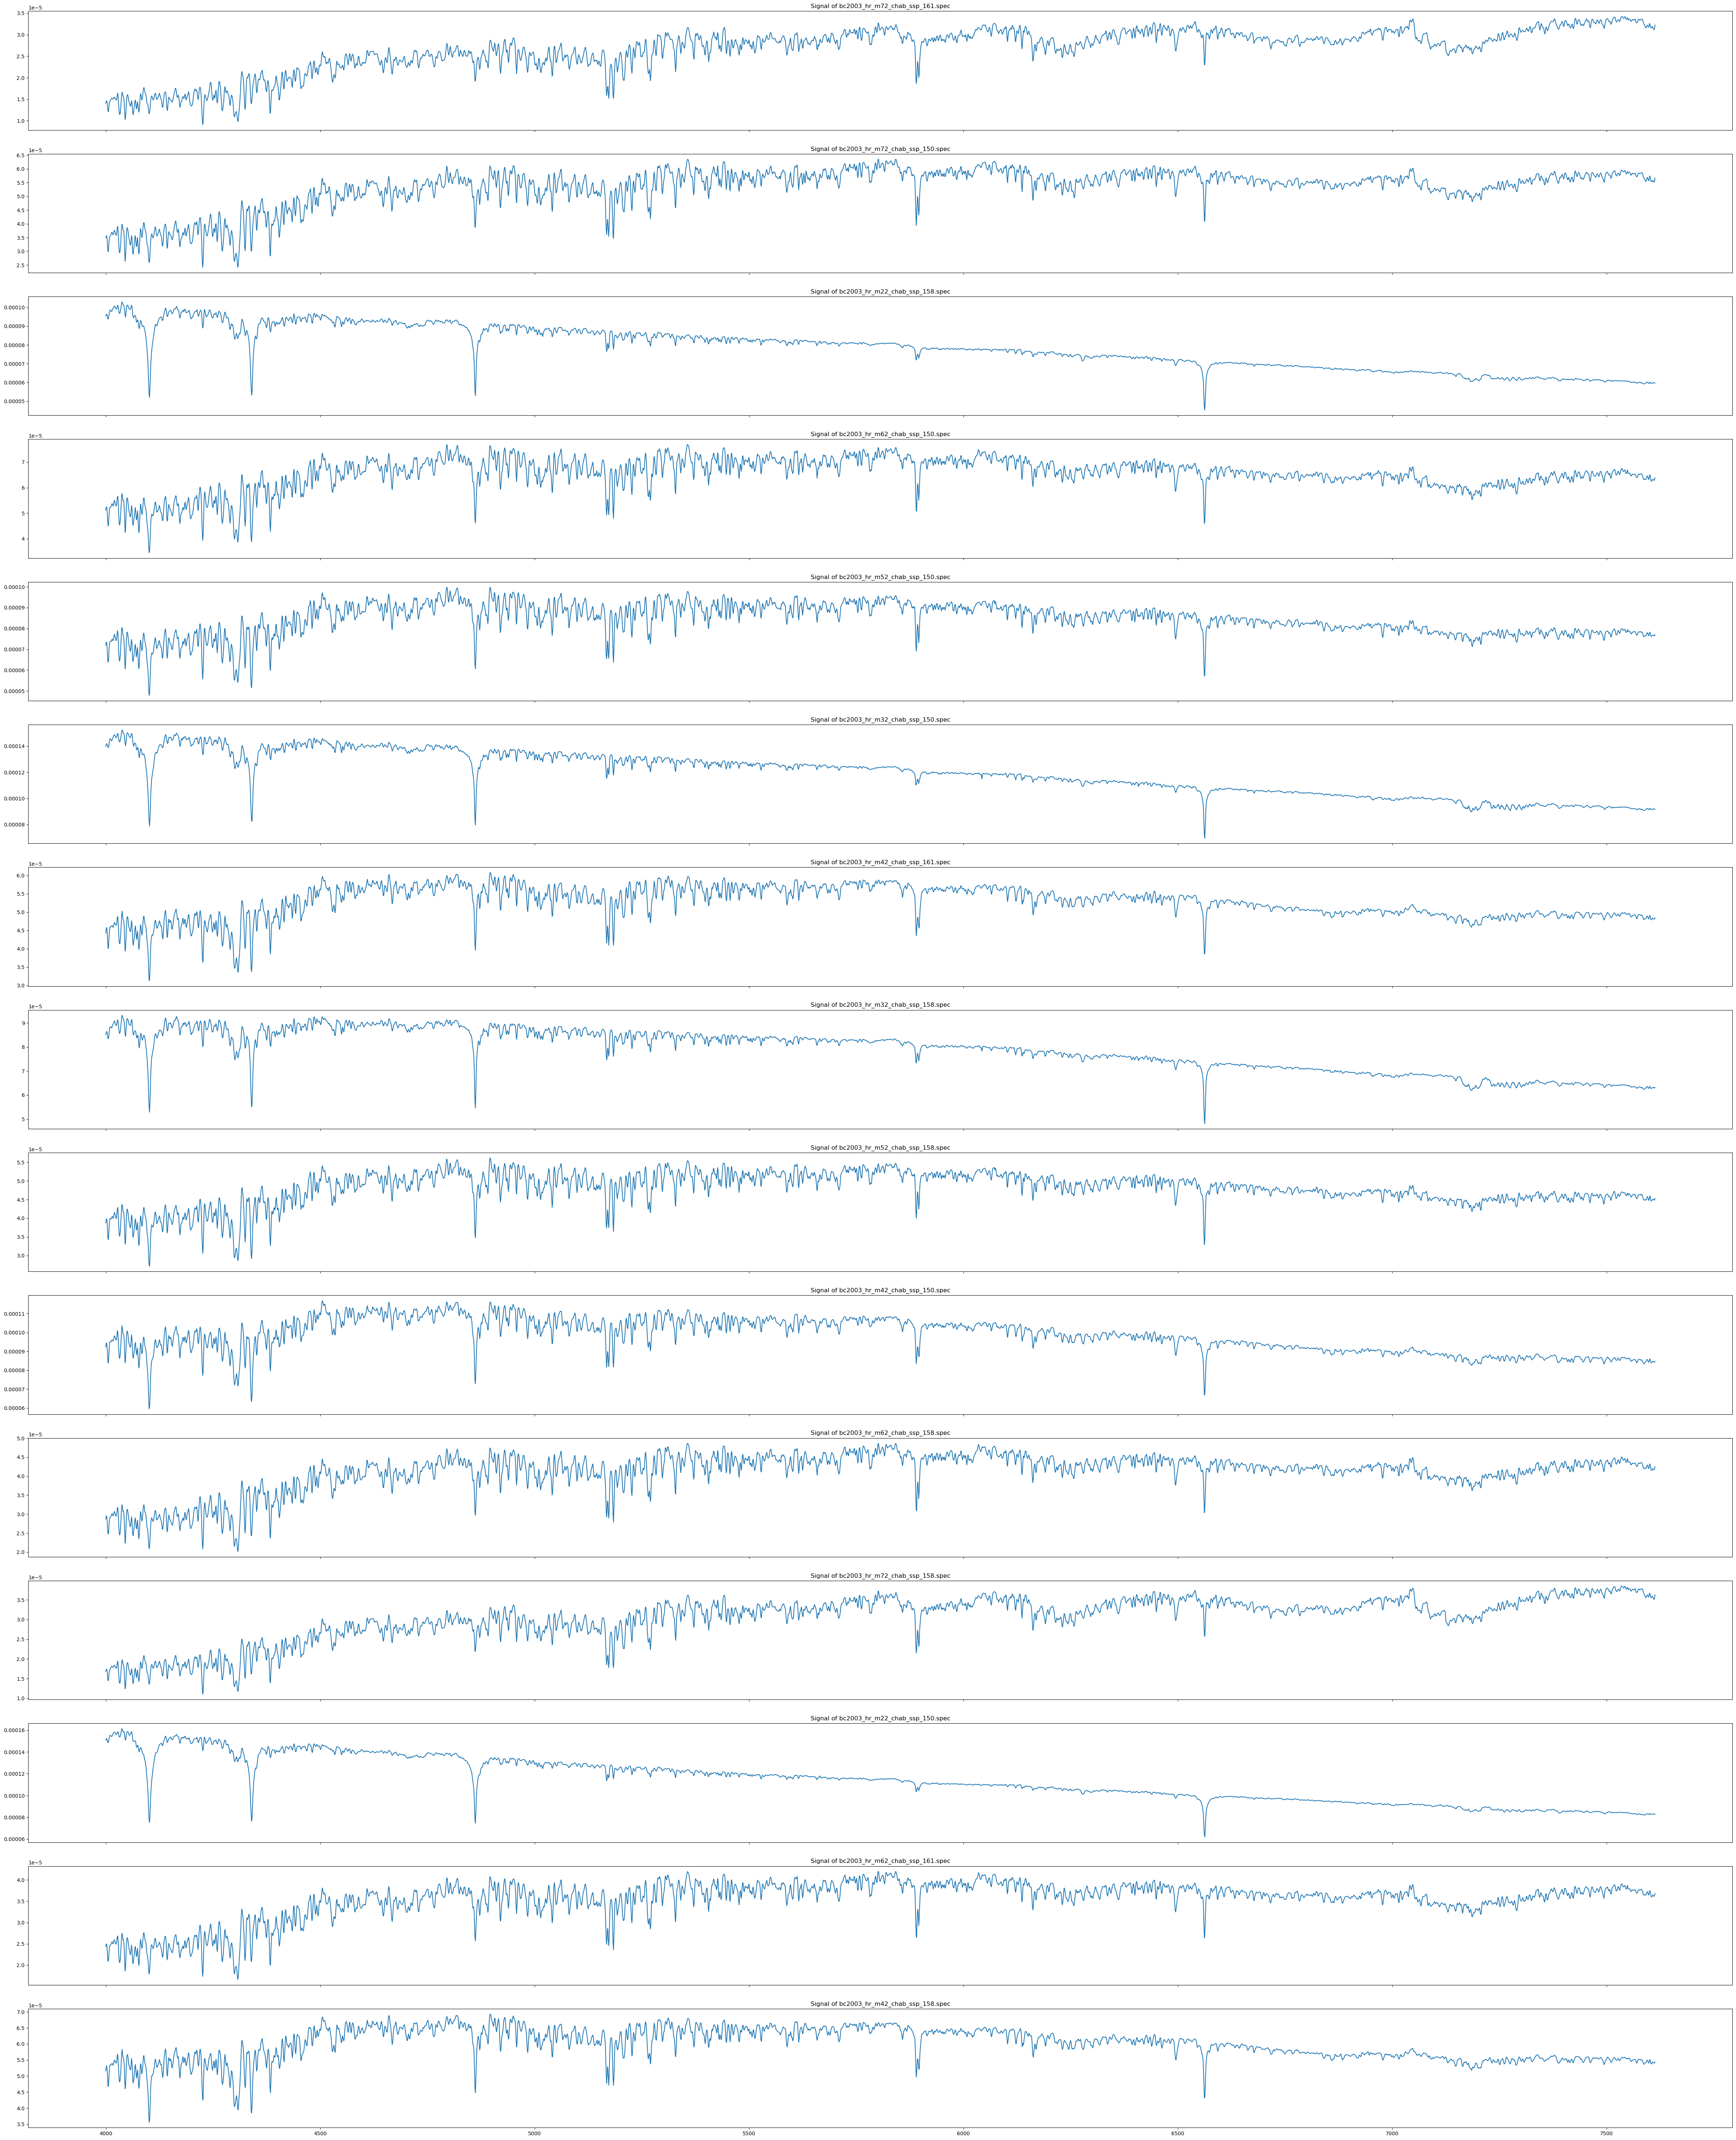

In [9]:
target_bases_filenames = list(target_bases.keys())
lambdamin = corrected_wl.min()
lambdamax = corrected_wl.max()

inspect_absortion_ref(target_bases_filenames, lambdamin, lambdamax, lick)

#### Beam map

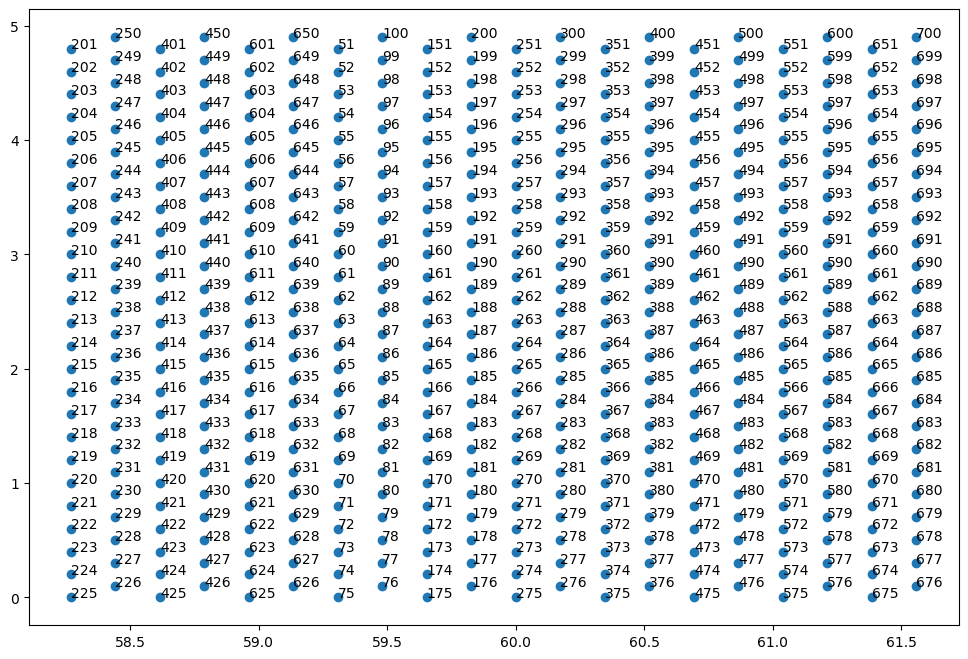

In [239]:
mdf_sky = tomo.mdf[tomo.mdf["XINST"] > 10]

fig, ax = plt.subplots(figsize=(12, 8))
ax.scatter(mdf_sky["XINST"], mdf_sky["YINST"])

for row in mdf_sky:
    ax.annotate(str(row["NO"]), (row["XINST"], row["YINST"]))

plt.show()